# TomoSAR TSNN Model building, Training, and Testing Using Pytorch Lightning

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTHONWARNINGS"] = "ignore"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"  
import torch
torch.set_float32_matmul_precision('medium')

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import joblib
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_


# DATA SPLITTING SECTION
# original large labeled dataset
if not (os.path.exists('train2_data.npz') and os.path.exists('val2_data.npz') and os.path.exists('test2_labeled_data.npz')):
    data = np.load('train_data.npz') 
    X = data['X']
    yc = data['yc']
    yg = data['yg']

    # Split: 80% train, 10% val, 10% test
    X_train, X_temp, yc_train, yc_temp, yg_train, yg_temp = train_test_split(
        X, yc, yg, test_size=0.2, random_state=42
    )
    X_val, X_test, yc_val, yc_test, yg_val, yg_test = train_test_split(
        X_temp, yc_temp, yg_temp, test_size=0.5, random_state=42
    )

    np.savez('train_data.npz', X=X_train, yc=yc_train, yg=yg_train)
    np.savez('val_data.npz', X=X_val, yc=yc_val, yg=yg_val)
    np.savez('test_labeled_data.npz', X=X_test, yc=yc_test, yg=yg_test)
    print("Data split and saved: train_data.npz, val_data.npz, test_labeled_data.npz")

### model architecture
class HeightDataset(Dataset):
    def __init__(self, X, yc=None, yg=None):
        self.X = X
        self.yc = yc
        self.yg = yg

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32)
        if self.yc is not None and self.yg is not None:
            return x, torch.tensor(self.yc[idx], dtype=torch.long), torch.tensor(self.yg[idx], dtype=torch.long)
        return x

# 
class HeightDataModule(pl.LightningDataModule):
    def __init__(self, train_npz, val_npz, test_npz, scaler_path='tsnn_scaler.pkl', batch_size=32, num_workers=0):
        super().__init__()
        self.train_npz = train_npz
        self.val_npz = val_npz
        self.test_npz = test_npz
        self.scaler_path = scaler_path
        self.batch_size = batch_size
        self.num_workers = num_workers

    def prepare_data(self):
        if not os.path.exists(self.scaler_path):
            train_data = np.load(self.train_npz, mmap_mode='r')
            X = train_data['X']
            scaler = StandardScaler()
            for i in range(0, X.shape[0], 32):
                scaler.partial_fit(X[i:i+32])
            joblib.dump(scaler, self.scaler_path)
            print("Scaler fitted and saved!")
        else:
            print("Scaler already exists, skipping fit.")

    def setup(self, stage=None):
        scaler = joblib.load(self.scaler_path)

        train_data = np.load(self.train_npz)
        X_train = scaler.transform(train_data['X'])
        self.train_ds = HeightDataset(X_train, train_data['yc'], train_data['yg'])

        val_data = np.load(self.val_npz)
        X_val = scaler.transform(val_data['X'])
        self.val_ds = HeightDataset(X_val, val_data['yc'], val_data['yg'])

        test_data = np.load(self.test_npz)
        X_test = scaler.transform(test_data['X'])
        self.test_ds = HeightDataset(X_test, test_data['yc'], test_data['yg'])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False, num_workers=self.num_workers, pin_memory=True)

class TSNN(nn.Module):
    def __init__(self, input_dim=52, num_classes=61, hidden=400, dropout_p=0.2):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)]
        for _ in range(7):
            layers.extend([nn.Linear(hidden, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)])
        layers.extend([nn.Linear(hidden, hidden), nn.BatchNorm1d(hidden), nn.ReLU(), nn.Dropout(dropout_p)])
        layers.append(nn.Linear(hidden, num_classes))
        self.net = nn.Sequential(*layers)
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        return self.net(x)

#
class TSNNLitModule(pl.LightningModule):
    def __init__(self, input_dim=52, num_classes_c=61, num_classes_g=41, hidden=400, dropout_p=0.2, lr=5e-5, wd=1e-4):
        super().__init__()
        self.save_hyperparameters()
        self.model_c = TSNN(input_dim, num_classes_c, hidden, dropout_p)
        self.model_g = TSNN(input_dim, num_classes_g, hidden, dropout_p)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = lr
        self.wd = wd

    def forward(self, x):
        return self.model_c(x), self.model_g(x)

    def training_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('train/loss_c', loss_c, prog_bar=True)
        self.log('train/loss_g', loss_g, prog_bar=True)
        self.log('train/loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('val/loss_c', loss_c, prog_bar=True)
        self.log('val/loss_g', loss_g, prog_bar=True)
        self.log('val/loss', loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, yc, yg = batch
        pred_c = self.model_c(x)
        pred_g = self.model_g(x)
        loss_c = self.criterion(pred_c, yc)
        loss_g = self.criterion(pred_g, yg)
        loss = loss_c + loss_g
        self.log('test/loss_c', loss_c, prog_bar=True)
        self.log('test/loss_g', loss_g, prog_bar=True)
        self.log('test/loss', loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(list(self.model_c.parameters()) + list(self.model_g.parameters()), lr=self.lr, weight_decay=self.wd)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
        return {"optimizer": optimizer, "lr_scheduler": {"scheduler": scheduler, "monitor": "val/loss"}}

    def on_before_zero_grad(self, optimizer):
        clip_grad_norm_(self.model_c.parameters(), 1.0)
        clip_grad_norm_(self.model_g.parameters(), 1.0)

FileNotFoundError: [Errno 2] No such file or directory: 'train_data.npz'

In [ ]:
# TRAINING SCRIPT
pl.seed_everything(42)
data = HeightDataModule(
    train_npz='train_data.npz',
    val_npz='val_data.npz',
    test_npz='test_labeled_data.npz',
    scaler_path='tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0      #os.cpu_count()
)

model = TSNNLitModule()  # Default lr=5e-5,

# Callbacks
checkpoint_cb = pl.callbacks.ModelCheckpoint(monitor='val/loss', save_top_k=1, mode='min', filename='best-tsnn')
early_stop_cb = pl.callbacks.EarlyStopping(monitor='val/loss', patience=20, mode='min')

trainer = pl.Trainer(
    max_epochs=200,
    accelerator='auto',    # GPU if available, else CPU
    devices='auto',        # All available GPUs/CPUs
    callbacks=[checkpoint_cb, early_stop_cb],
    log_every_n_steps=10,
    strategy="auto",
)
trainer.fit(model, datamodule=data)
#trainer.test(model, datamodule=data)

In [3]:
import torch
model = torch.load('/home/krschap/sahar/lightning_logs/version_5/checkpoints/best-tsnn.ckpt')

# START

In [ ]:
#!uv pip install h5py

import h5py
mat_path = 'Covariance_matrices_fullpol.mat'
with h5py.File(mat_path, 'r') as f:
    print("Available variables:", list(f.keys()))
    
with h5py.File(mat_path, 'r') as f:
    cov = f['covariance']
    print("Raw shape:", cov.shape)
    print("Dtype:", cov.dtype)


Resolved 219 packages in 0.68ms
Audited 213 packages in 0.03ms


In [ ]:
# Load the .mat file
mat_file_path = 'Datasets_TomoSar/dataset_Guiana_6FPimages_Pband.mat'
mat_data = scipy.io.loadmat(mat_file_path)
# Display variable names, types, and shapes
print("Contents of the .mat file:")
for var_name, var_value in mat_data.items():
    # Skip default MATLAB metadata fields
    if var_name.startswith('__'):
        continue
    print(f"Variable: {var_name}")
    print(f"    Type: {type(var_value)}")
    try:
        print(f"   Shape: {var_value.shape}")
    except AttributeError:
        print("  No shape (probably not a NumPy array)")
    print()

    
# Extract LiDAR variables
#reatlive hight
CHM = mat_data['CHM']
DTM = mat_data['DTM']

#absolute physical hoieght
real_DTM = DTM + 25
real_CHM = DTM + CHM + 25

plt.figure(figsize=(10, 8))

# Plot
plt.subplot(1, 2, 1)
plt.imshow(real_DTM, cmap='terrain')
plt.title('Digital Terrain Model (DTM)+25')
plt.axis('off')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(real_CHM, cmap='viridis')
plt.title('Canopy Height Model (CHM) +25')
plt.axis('off')
plt.colorbar()


plt.tight_layout()

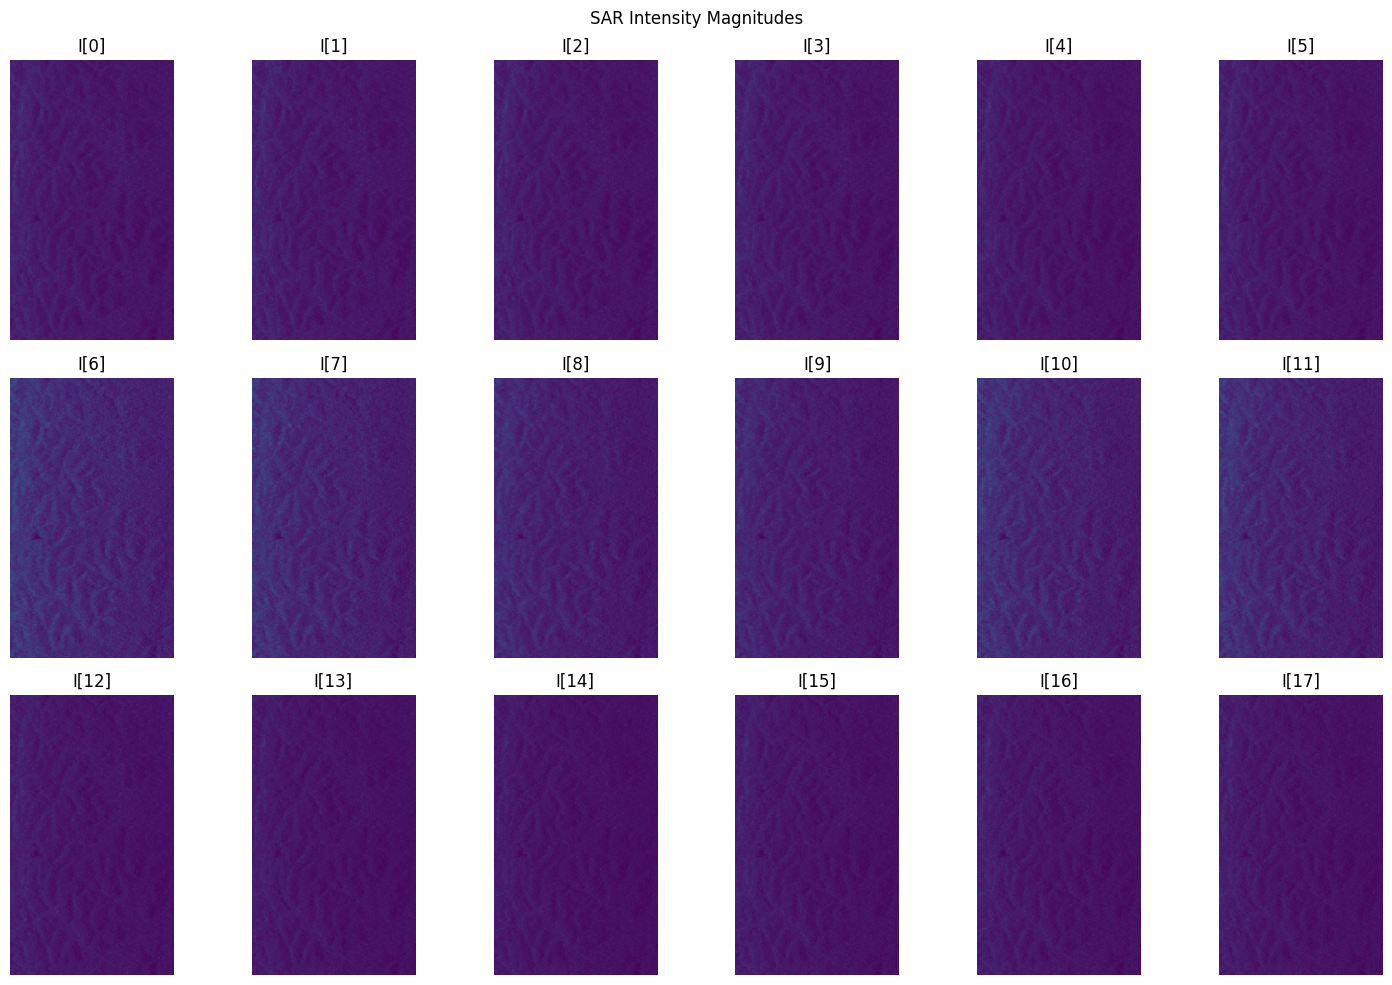

In [10]:
#ploting the images ! 18

import matplotlib.pyplot as plt
I = mat_data['I']
plt.figure(figsize=(15, 10))
for i in range(18):
    plt.subplot(3, 6, i + 1)
    plt.imshow(np.abs(I[:, :, i]), cmap='viridis')
    plt.title(f'I[{i}]')
    plt.axis('off')

plt.suptitle("SAR Intensity Magnitudes")
plt.tight_layout()
plt.show()

In [ ]:
kz = mat_data['kz']
print(f"Number of images in I: {kz.shape[2]}")
kz = mat_data['kz']


# Plot a few kz layers (shape: 2450 x 1428 x 6)
num_kz = kz.shape[2]
plt.figure(figsize=(12, 6))
for i in range(min(6, num_kz)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(kz[:, :, i], cmap='plasma')
    plt.title(f'kz[:, :, {i}]')
    plt.axis('off')
plt.suptitle('Vertical Wavenumber kz')
plt.tight_layout()
plt.show()

Number of images in I: 6


In [ ]:
import mlflow 

mlflow.autolog(log_models=True)
mlflow.set_tracking_uri('https://mlflow.krschap.tech')

from dotenv import load_dotenv

load_dotenv() # loads env from .env for the s3 configuration to log artifacts into the server
#mlflow.log_artifact("./untitled.txt")

2025/08/06 15:17:54 WARNING mlflow.utils.autologging_utils: MLflow pytorch autologging is known to be compatible with 2.1.0 <= torch <= 2.7.1, but the installed version is 2.7.1+cu126. If you encounter errors during autologging, try upgrading / downgrading torch to a compatible version, or try upgrading MLflow.
2025/08/06 15:17:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for pytorch_lightning.
2025/08/06 15:17:54 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 1.3.0 <= scikit-learn <= 1.7.0, but the installed version is 1.7.1. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.
2025/08/06 15:17:54 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [3]:
import numpy as np

train = np.load("train_data.npz")
print("CHM min/max:", train["yc"].min(), train["yc"].max())
print("DTM min/max:", train["yg"].min(), train["yg"].max())


FileNotFoundError: [Errno 2] No such file or directory: 'train_data.npz'

# Training

In [17]:
# ---------- 6. TRAINING SCRIPT ----------

pl.seed_everything(42)
data = HeightDataModule(
    train_npz='train_data.npz',
    val_npz='val_data.npz',
    test_npz='test_labeled_data.npz',
    scaler_path='tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0      #os.cpu_count()
)


Seed set to 42


In [18]:
model = TSNNLitModule()  # Default lr=5e-5, adjust as needed

# Callbacks
checkpoint_cb = pl.callbacks.ModelCheckpoint(monitor='val/loss', save_top_k=1, mode='min', filename='best-tsnn')
early_stop_cb = pl.callbacks.EarlyStopping(monitor='val/loss', patience=20, mode='min')

trainer = pl.Trainer(
    max_epochs=100,
    accelerator='auto',    # GPU if available, else CPU
    devices='auto',        # All available GPUs/CPUs
    callbacks=[checkpoint_cb, early_stop_cb],
    log_every_n_steps=10,
    strategy="auto",
)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [19]:
trainer.fit(model, datamodule=data)

2025/07/30 13:11:30 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '0e763633fd3544019966f885837d0059', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current pytorch workflow
2025/07/30 13:11:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/krschap/sahar/.venv/lib/python3.11/site-packages/mlflow/pytorch/_lightning_autolog.py:466: UserWarning: Autologging is known to be compatible with pytorch-lightning versions between 2.0.4 and 2.5.1.post0 and may not succeed with packages outside this range."
INFO: You are using a CUDA device ('NVIDIA GeForce RTX 4090 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_

Scaler already exists, skipping fit.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params | Mode 
-------------------------------------------------------
0 | model_c   | TSNN             | 1.3 M  | train
1 | model_g   | TSNN             | 1.3 M  | train
2 | criterion | CrossEntropyLoss | 0      | train
-------------------------------------------------------
2.7 M     Trainable params
0         Non-trainable params
2.7 M     Total params
10.656    Total estimated model params size (MB)
79        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

/home/krschap/sahar/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/krschap/sahar/.venv/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |                                                                                                   …

Validation: |                                                                                                 …

2025/07/30 13:16:17 WARNING mlflow.utils.checkpoint_utils: Checkpoint logging is skipped, because checkpoint 'save_best_only' config is True, it requires to compare the monitored metric value, but the provided monitored metric value is not available.
INFO: `Trainer.fit` stopped: `max_epochs=1` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.
2025/07/30 13:16:18 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during pytorch autologging: Failed to upload /tmp/tmp87d6worh/model_summary.txt to mlflow/0/0e763633fd3544019966f885837d0059/artifacts/model_summary.txt: An error occurred (InvalidAccessKeyId) when calling the PutObject operation: The AWS Access Key Id you provided does not exist in our records.


🏃 View run able-snail-920 at: https://mlflow.krschap.tech/#/experiments/0/runs/0e763633fd3544019966f885837d0059
🧪 View experiment at: https://mlflow.krschap.tech/#/experiments/0


In [ ]:
trainer.test(model, datamodule=data)

## TEST Model

In [ ]:
from glob import glob

ckpts = glob('lightning_logs/version_5/checkpoints/best-tsnn.ckpt')
print(ckpts)
best_ckpt_path = ckpts[0]
print("Best checkpoint path:", best_ckpt_path)



data = HeightDataModule(
    train_npz='train_data.npz',
    val_npz='val_data.npz',
    test_npz='test_labeled_data.npz',
    scaler_path='tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0
)


model = TSNNLitModule.load_from_checkpoint(best_ckpt_path)

trainer = pl.Trainer(accelerator='auto', devices='auto')
trainer.test(model, datamodule=data)


## test
model = TSNNLitModule.load_from_checkpoint(best_ckpt_path)


data = HeightDataModule(
    train_npz='train_data.npz',
    val_npz='val_data.npz',
    test_npz='test_labeled_data.npz',
    scaler_path='tsnn_scaler.pkl',
    batch_size=32,
    num_workers=0
)
data.setup()
test_loader = data.test_dataloader()



['lightning_logs/version_5/checkpoints/best-tsnn.ckpt']
Best checkpoint path: lightning_logs/version_5/checkpoints/best-tsnn.ckpt


In [ ]:
import torch

device = model.device if hasattr(model, 'device') else next(model.parameters()).device

all_preds_c, all_preds_g = [], []
all_yc, all_yg = [], []

model.eval()
with torch.no_grad():
    for x, yc, yg in test_loader:
        # Move data to the same device as the model
        x = x.to(device)
        yc = yc.to(device)
        yg = yg.to(device)

        pred_c, pred_g = model(x)
        all_preds_c.append(torch.argmax(pred_c, dim=1).cpu())  # Move to cpu for numpy later
        all_preds_g.append(torch.argmax(pred_g, dim=1).cpu())
        all_yc.append(yc.cpu())
        all_yg.append(yg.cpu())


# Concatenate all batches
all_preds_c = torch.cat(all_preds_c).cpu().numpy()
all_preds_g = torch.cat(all_preds_g).cpu().numpy()
all_yc = torch.cat(all_yc).cpu().numpy()
all_yg = torch.cat(all_yg).cpu().numpy()

## accuracy
from sklearn.metrics import accuracy_score
print ("acuuracy yc:", accuracy_score(all_yc, all_preds_c))
print ("acuuracy yg:", accuracy_score(all_yg, all_preds_g))

## Visualsation

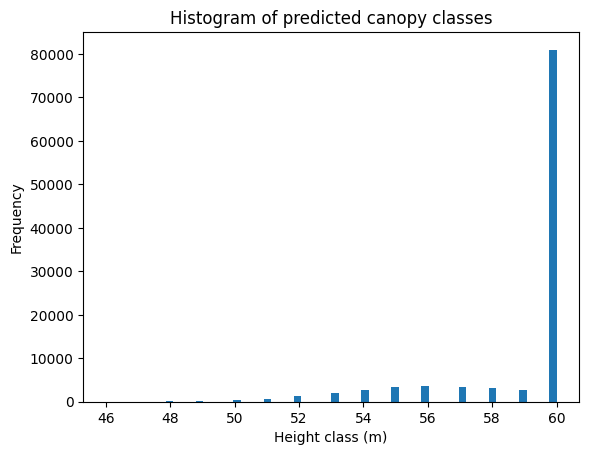

In [73]:
import matplotlib.pyplot as plt

plt.hist(all_yc, bins=60)
plt.title("Histogram of predicted canopy classes")
plt.xlabel("Height class (m)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print(type(all_preds_g))
print(len(all_preds_g))
print(type(all_preds_g[0]))
print(all_preds_g[0].shape if hasattr(all_preds_g[0], 'shape') else len(all_preds_g[0]))

import torch
import numpy as np

# Convert list of tensors to one flat numpy array
all_preds_g_tensor = torch.cat(all_preds_g)  # shape: (104992,)
all_preds_g_flat = all_preds_g_tensor[:len(all_yg)].numpy()  # now shape: (104656,)

print(type(all_preds_g_flat))
print(all_preds_g_flat.shape)

print("Preds shape:", all_preds_g_flat.shape)
print("GT shape:", all_yg.shape)
print("First 5:", all_preds_g_flat[:5], all_yg[:5])

print("CHM prediction unique values:", np.unique(chm_pred_map))
print("DTM prediction unique values:", np.unique(dtm_pred_map))

chm_pred_m = all_preds_c.astype(np.float32)   # predicted canopy height
chm_true_m = all_yc.astype(np.float32)

dtm_pred_m = all_preds_g.astype(np.float32)   # predicted ground height
dtm_true_m = all_yg.astype(np.float32)


<class 'list'>
3281
<class 'torch.Tensor'>
torch.Size([32])


In [83]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

chm_rmse = mean_squared_error(chm_true_m, chm_pred_m)
chm_r2 = r2_score(chm_true_m, chm_pred_m)

print(f"CHM RMSE: {chm_rmse:.2f} m")
print(f"CHM R²: {chm_r2:.2f}")


CHM RMSE: 0.10 m
CHM R²: 0.98


In [ ]:
import h5py
import numpy as np
from scipy.io import loadmat

sar_cube = 'Datasets_TomoSar/Covariance_matrices_fullpol.mat'
with h5py.File(sar_cube, 'r') as f:
    print("Available variables:", list(f.keys()))

with h5py.File(sar_cube, 'r') as f:
    cov = f['covariance']
    print("Raw shape:", cov.shape)
    print("Dtype:", cov.dtype)
# Extract patch
X_patch = sar_cube[row_start:row_end, col_start:col_end, :, :]  # shape (324, 324, 18, 18)

# Flatten 18x18 matrix to vector
X_patch = X_patch.reshape(324, 324, -1)  # (324, 324, 324)
X_patch = X_patch.reshape(-1, 324)       # (104976, 324)

yc_patch = CHM[row_start:row_end, col_start:col_end].astype(np.int64).reshape(-1)
yg_patch = DTM[row_start:row_end, col_start:col_end].astype(np.int64).reshape(-1)

#loading mat files
with h5py.File('Datasets_TomoSar/Covariance_matrices_fullpol.mat', 'r') as f:
    sar_cube_struct = f['covariance'][:]  # shape (1428, 2450, 18, 18)
    # Convert structured dtype to complex array
    sar_cube = sar_cube_struct['real'] + 1j * sar_cube_struct['imag']

# Load CHM and DTM from .mat (v7.2 or lower)
mat_data = loadmat('Datasets_TomoSar/dataset_Guiana_6FPimages_Pband.mat')
CHM = mat_data['CHM']
DTM = mat_data['DTM']

real_CHM = CHM + DTM + 25
real_DTM = DTM + 25

row_start, row_end = 1000, 1324
col_start, col_end = 800, 1124



np.savez('test_patch.npz', X=X_patch, yc=yc_patch, yg=yg_patch)
print("Saved test_patch.npz!")

#    
def extract_52_features_from_cov(cov_cube):
    """
    cov_cube: numpy array of shape (H, W, 18, 18), complex-valued
    Returns: (H, W, 52), where each pixel is a feature vector of 52 complex values
    """
    H, W, _, _ = cov_cube.shape
    features = np.zeros((H, W, 52), dtype=np.complex128)

    for i in range(H):
        for j in range(W):
            cov = cov_cube[i, j]  # shape (18, 18), complex matrix

            # Diagonal elements (18)
            diag = np.diag(cov)

            # First row (excluding diagonal) [0,1] to [0,17] — 17 elements
            first_row = cov[0, 1:]

            # First column (excluding diagonal) [1,0] to [17,0] — 17 elements
            first_col = cov[1:, 0]

            # Concatenate all 52 features
            features[i, j] = np.concatenate([diag, first_row, first_col])

    return features



Available variables: ['covariance']


In [ ]:
# complex array: shape (1428, 2450, 18, 18)
# Extract patch
patch = sar_cube[row_start:row_end, col_start:col_end, :, :]  # (324, 324, 18, 18)

# Extract 52 complex features per pixel
X_patch_complex = extract_52_features_from_cov(patch)  # (324, 324, 52)

# Reshape to (N, 52)
X_patch_complex = X_patch_complex.reshape(-1, 52)

# Convert complex to real input: separate real + imag parts
X_real = np.real(X_patch_complex)
X_imag = np.imag(X_patch_complex)
X_combined = np.hstack([X_real, X_imag])  # (N, 104)

# OR: If scaler trained on real part only
X_input = X_real  # (N, 52)

# Load and apply scaler
import joblib
scaler = joblib.load('tsnn_scaler.pkl')
X_scaled = scaler.transform(X_input)  # to match feature count shape

# Load and scale the patch
from sklearn.preprocessing import StandardScaler
import joblib
#scaler = joblib.load('tsnn_scaler.pkl')

data_patch = np.load('test_patch.npz')
#X_patch = scaler.transform(data_patch['X'])
yc_patch = data_patch['yc']
yg_patch = data_patch['yg']

# Create dataset + dataloader
from torch.utils.data import TensorDataset, DataLoader
import torch

dataset = TensorDataset(torch.tensor(X_scaled, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32)

# Run inference
model = TSNNLitModule.load_from_checkpoint("lightning_logs/version_5/checkpoints/best-tsnn.ckpt")
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

all_preds_c, all_preds_g = [], []
with torch.no_grad():
    for x in loader:
        x = x[0].to(device)
        pc, pg = model(x)
        all_preds_c.append(torch.argmax(pc, dim=1).cpu())
        all_preds_g.append(torch.argmax(pg, dim=1).cpu())

# Combine results
pred_c = torch.cat(all_preds_c).numpy().reshape(324, 324)
pred_g = torch.cat(all_preds_g).numpy().reshape(324, 324)

true_c = yc_patch.reshape(324, 324)
true_g = yg_patch.reshape(324, 324)


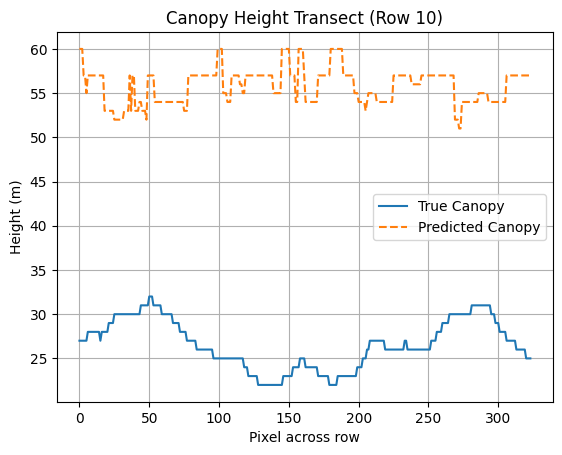

In [117]:
row = 10  # pick a row in the patch
plt.plot(true_c[row], label="True Canopy")
plt.plot(pred_c[row], label="Predicted Canopy", linestyle='--')
plt.title("Canopy Height Transect (Row {})".format(row))
plt.xlabel("Pixel across row")
plt.ylabel("Height (m)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data = np.load('test_labeled_data.npz')
print("Keys:", data.files)  # shows variable names inside

# print shape of each item
for key in data.files:
    print(f"{key}: shape = {data[key].shape}, dtype = {data[key].dtype}")


Keys: ['X', 'yc', 'yg']
X: shape = (104656, 52), dtype = float32
yc: shape = (104656,), dtype = int64
yg: shape = (104656,), dtype = int64


In [ ]:
h, w = 323, 324

# Reshape to 2D maps
chm_pred_map = all_preds_c[:h*w].reshape(h, w)
chm_true_map = all_yc[:h*w].reshape(h, w)

dtm_pred_map = all_preds_g[:h*w].reshape(h, w)
dtm_true_map = all_yg[:h*w].reshape(h, w)

print("Train data size:", np.load("train_data.npz")["X"].shape[0])
print("Val data size:", np.load("val_data.npz")["X"].shape[0])
print("Test data size:", np.load("test_labeled_data.npz")["X"].shape[0])

import math
print("Approx shape:", math.isqrt(104656))  

h, w = 323, 324  # total = 104652
chm_pred_map = all_preds_c[:h*w].reshape(h, w)
dtm_pred_map = all_preds_g[:h*w].reshape(h, w)

start_y, start_x = 1000, 600 

lidar_chm_patch = CHM[start_y:start_y+h, start_x:start_x+w]
lidar_dtm_patch = DTM[start_y:start_y+h, start_x:start_x+w]


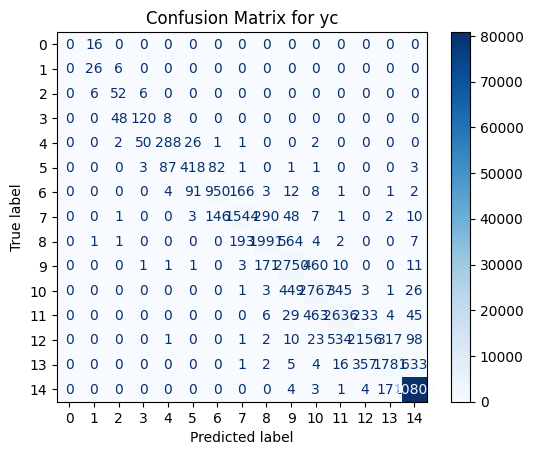

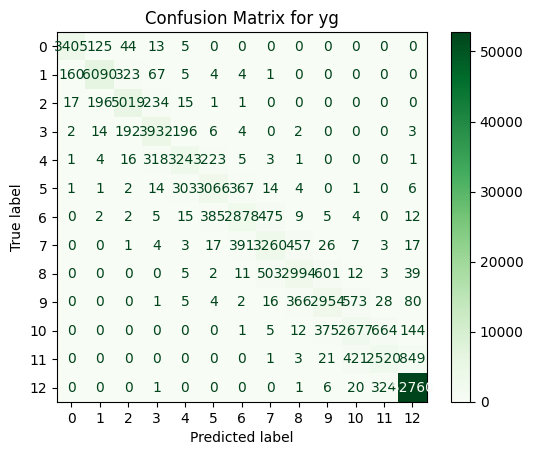

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# For yc (category/class c)
cm_c = confusion_matrix(all_yc, all_preds_c)
disp_c = ConfusionMatrixDisplay(confusion_matrix=cm_c)
disp_c.plot(cmap="Blues")
plt.title("Confusion Matrix for yc")
plt.show()

# For yg (category/class g)
cm_g = confusion_matrix(all_yg, all_preds_g)
disp_g = ConfusionMatrixDisplay(confusion_matrix=cm_g)
disp_g.plot(cmap="Greens")
plt.title("Confusion Matrix for yg")
plt.show()

# Test on  Unlabeld data

In [ ]:
#unlabeled data

import numpy as np

data = np.load("test_data.npz")
print(data.files)


unlabeled_data = np.load('test_data.npz')
X_unlabeled = unlabeled_data['X'] 
row_indices = data['indices']

['X', 'indices']


In [ ]:
unlabeled_data = np.load('test_data.npz')
print(unlabeled_data.files)  # ['X', 'indices']

# shape of the data array 
print(unlabeled_data['X'].shape)


scaler = joblib.load('tsnn_scaler.pkl')
X_unlabeled_scaled = scaler.transform(X_unlabeled)


# Convert to Torch tensor and move to device
X_tensor = torch.tensor(X_unlabeled_scaled, dtype=torch.float32)
device = model.device if hasattr(model, 'device') else next(model.parameters()).device
X_tensor = X_tensor.to(device)
print(device)


# Predict with the model
model.eval()
with torch.no_grad():
    preds_c, preds_g = model(X_tensor)
    pred_classes_c = torch.argmax(preds_c, dim=1).cpu().numpy()
    pred_classes_g = torch.argmax(preds_g, dim=1).cpu().numpy()



# Save predictions
np.savez('unlabeled_predictions.npz', 
         pred_c=pred_classes_c, 
         pred_g=pred_classes_g, 
         indices=row_indices)
print("Predictions saved to unlabeled_predictions.npz")


# results = np.load('unlabeled_predictions.npz')
# print(results.files)  # ['pred_c', 'pred_g', 'indices']

['X', 'indices']
(943540, 52)


In [ ]:
results = np.load('unlabeled_predictions.npz')
for key in results.files:
    print(f"{key}: {results[key].shape}")


pred_c = results['pred_c']        # Predictions for category c
pred_g = results['pred_g']        # Predictions for category g
indices = results['indices']      # Row indices

## reading it as  df
df = pd.read_csv('unlabeled_predictions.csv')
print(df.shape)


df = pd.DataFrame({
    'index': indices,
    'pred_c': pred_c,
    'pred_g': pred_g
})
df.to_csv('unlabeled_predictions.csv', index=False)
print("Saved as unlabeled_predictions.csv")



data = np.load('test_data.npz')
indices = data['indices']
pred_c = np.load('unlabeled_predictions.npz')['pred_c']
pred_g = np.load('unlabeled_predictions.npz')['pred_g']

assert len(indices) == len(pred_c) == len(pred_g) == 943540

df = pd.DataFrame({
    'index': indices,
    'pred_c': pred_c,
    'pred_g': pred_g
})
df.to_csv('unlabeled_predictions_matched.csv', index=False)
print("CSV saved with shape:", df.shape)

pred_c: (943540,)
pred_g: (943540,)
indices: (943540,)


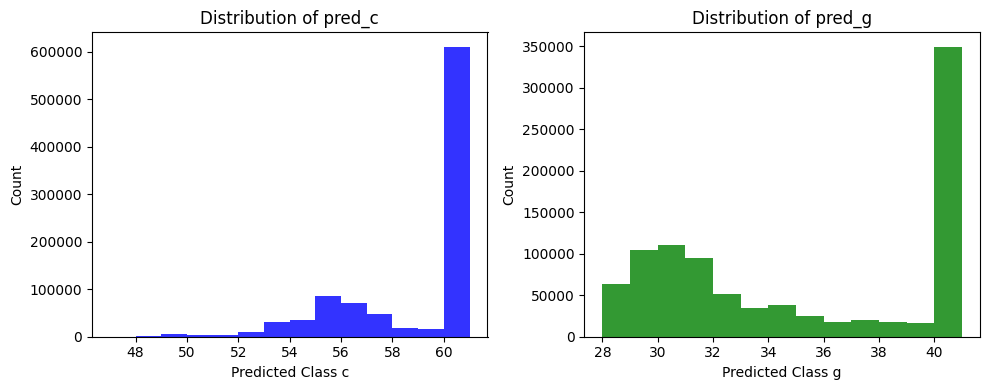

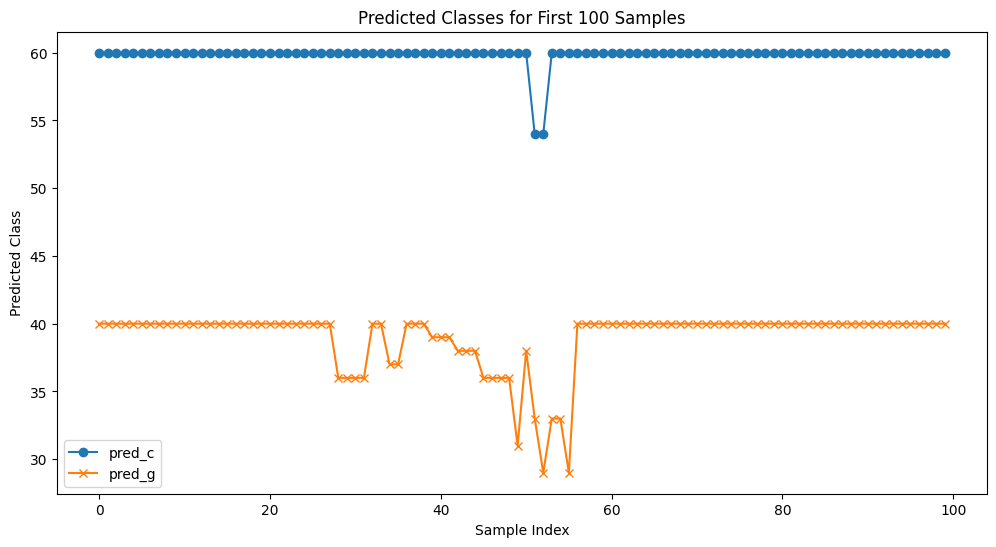

In [ ]:
# Load the predictions CSV
df = pd.read_csv('unlabeled_predictions_matched.csv')

# Distribution Histogram for pred_c and pred_g
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(df['pred_c'], bins=range(df['pred_c'].min(), df['pred_c'].max() + 2), alpha=0.8, color='blue')
plt.title('Distribution of pred_c')
plt.xlabel('Predicted Class c')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.hist(df['pred_g'], bins=range(df['pred_g'].min(), df['pred_g'].max() + 2), alpha=0.8, color='green')
plt.title('Distribution of pred_g')
plt.xlabel('Predicted Class g')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plot predicted classes for a sample of data points
N = 100
plt.figure(figsize=(12, 6))
plt.plot(df['pred_c'][:N], 'o-', label='pred_c')
plt.plot(df['pred_g'][:N], 'x-', label='pred_g')
plt.title(f'Predicted Classes for First {N} Samples')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Class')
plt.legend()
plt.show()

In [ ]:
from scipy.io import loadmat

test_data = np.load('test_labeled_data.npz')
print("Keys:", test_data.files)

for k in test_data.files:
    print(f"{k}: shape = {test_data[k].shape}, dtype = {test_data[k].dtype}")


mat = loadmat('Datasets_TomoSar/dataset_Guiana_6FPimages_Pband.mat')
CHM = mat['CHM'].T
DTM = mat['DTM'].T
real_DTM = DTM + 25
real_CHM = DTM + CHM + 25

valid_mask = ~np.isnan(real_CHM) & ~np.isnan(real_DTM)
valid_indices = np.argwhere(valid_mask)  # shape: (N_valid, 2)
print("Valid pixel positions:", valid_indices.shape)

# Get test pixel positions from the valid ones
test_indices = valid_indices[-len(all_preds_c):]


H, W = real_CHM.shape
yc_img = np.full((H, W), np.nan)
yg_img = np.full((H, W), np.nan)
pred_c_img = np.full((H, W), np.nan)
pred_g_img = np.full((H, W), np.nan)

for (r, c), yc, yg, pc, pg in zip(test_indices, all_yc, all_yg, all_preds_c, all_preds_g):
    yc_img[r, c] = yc
    yg_img[r, c] = yg
    pred_c_img[r, c] = pc
    pred_g_img[r, c] = pg


# DATA SPLITTING SECTION
if not (os.path.exists('trainy_data.npz') and os.path.exists('valy_data.npz') and os.path.exists('testy_labeled_data.npz')):
    data = np.load('split_data_/all_train_data.npz')
    X = data['X']
    yc = data['yc']
    yg = data['yg']

    total_size = X.shape[0]
    all_indices = np.arange(total_size)

    # Split: 80% train, 10% val, 10% test
    X_train, X_temp, yc_train, yc_temp, yg_train, yg_temp, idx_train, idx_temp = train_test_split(
        X, yc, yg, all_indices, test_size=0.2, random_state=42
    )
    X_val, X_test, yc_val, yc_test, yg_val, yg_test, idx_val, idx_test = train_test_split(
        X_temp, yc_temp, yg_temp, idx_temp, test_size=0.5, random_state=42
    )

    np.savez('split_data_/train_data.npz', X=X_train, yc=yc_train, yg=yg_train)
    np.savez('split_data_/val_data.npz', X=X_val, yc=yc_val, yg=yg_val)
    np.savez('split_data_/test_labeled_data.npz', X=X_test, yc=yc_test, yg=yg_test, indices=idx_test)

    print("Saved: train_data.npz, val_data.npz, test_labeled_data.npz (with test indices!)")

# Concatenate all batches
all_preds_c = torch.cat(all_preds_c).cpu().numpy()
all_preds_g = torch.cat(all_preds_g).cpu().numpy()
all_yc = torch.cat(all_yc).cpu().numpy()
all_yg = torch.cat(all_yg).cpu().numpy()



print("all yc", all_yc.shape)
print("all pred c", all_preds_c.shape)
print("idx test", idx_test.shape)
print("true_yc shape:", true_yc.shape)
print("pred_yc shape:", pred_yc.shape)
print("idx_test shape:", idx_test.shape)


Keys: ['X', 'yc', 'yg']
X: shape = (104656, 52), dtype = float32
yc: shape = (104656,), dtype = int64
yg: shape = (104656,), dtype = int64


In [ ]:
## path of the data
mat_data = scipy.io.loadmat('Datasets_TomoSar/dataset_Guiana_6FPimages_Pband.mat')
CHM = mat_data['CHM']
DTM = mat_data['DTM']
CHM = CHM.T
DTM = DTM.T
valid_mask = ~np.isnan(CHM) & ~np.isnan(DTM)
valid_indices = np.argwhere(valid_mask)

# Load original features/labels
data = np.load('split_data_/all_train_data.npz')
X = data['X']
yc = data['yc']
yg = data['yg']
idx = valid_indices  # shape (n_samples, 2)

# Split with indices preserving
X_train, X_temp, yc_train, yc_temp, yg_train, yg_temp, idx_train, idx_temp = train_test_split(
    X, yc, yg, idx, test_size=0.2, random_state=42
)
X_val, X_test, yc_val, yc_test, yg_val, yg_test, idx_val, idx_test = train_test_split(
    X_temp, yc_temp, yg_temp, idx_temp, test_size=0.5, random_state=42
)

# Save all with indices
np.savez('split_data_/train_data.npz', X=X_train, yc=yc_train, yg=yg_train, idx=idx_train)
np.savez('split_data_/val_data.npz', X=X_val, yc=yc_val, yg=yg_val, idx=idx_val)
np.savez('split_data_/test_labeled_data.npz', X=X_test, yc=yc_test, yg=yg_test, idx=idx_test)


# Visualize the predition task 4

In [ ]:
import h5py
import numpy as np

mat_path = 'Covariance_matrices_fullpol.mat'

with h5py.File(mat_path, 'r') as f:
    cov_raw = f['covariance'][:]  # shape: (1428, 2450, 18, 18)

# Reconstruct complex array: cov_raw is structured dtype
real = cov_raw['real']
imag = cov_raw['imag']
cov_complex = real + 1j * imag  # shape: (1428, 2450, 18, 18)

# Transpose to match CHM/DTM
cov_complex = np.transpose(cov_complex, (1, 0, 2, 3))  # shape: (2450, 1428, 18, 18)

H, W = 2450, 1428
features = np.zeros((H, W, 52), dtype=np.float32)

for i in range(H):
    for j in range(W):
        cov = cov_complex[i, j]  # shape (18, 18)

        # 18 real diagonal elements
        diag_real = np.real(np.diag(cov))

        # 17 off-diagonal from first row (cols 1–17)
        off_diag = cov[0, 1:18]
        off_real = np.real(off_diag)
        off_imag = np.imag(off_diag)

        vec = np.concatenate([diag_real, off_real, off_imag])  # 52-dim
        features[i, j, :] = vec


In [ ]:
#!uv pip install --force-reinstall numpy==1.26.4 scipy==1.13.1 streamlit==1.37.1 pillow==10.4.0 packaging==24.2 cachetools==5.5.0 watchdog==4.0.2

In [ ]:
X = features.reshape(-1, 52)

# Normalize
import joblib
scaler = joblib.load("tsnn_scaler.pkl")
X_scaled = scaler.transform(X)

import torch
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(torch.tensor(X_scaled, dtype=torch.float32))
loader = DataLoader(dataset, batch_size=32)

#import TSNNLitModule  
model = TSNNLitModule.load_from_checkpoint("best-tsnn.ckpt")
model.eval()

pred_c, pred_g = [], []
with torch.no_grad():
    for batch in loader:
        x = batch[0]
        pc, pg = model(x)
        pred_c.append(torch.argmax(pc, dim=1).cpu())
        pred_g.append(torch.argmax(pg, dim=1).cpu())

# Reshape to (H, W)
pred_c = torch.cat(pred_c).numpy().reshape(H, W)
pred_g = torch.cat(pred_g).numpy().reshape(H, W)


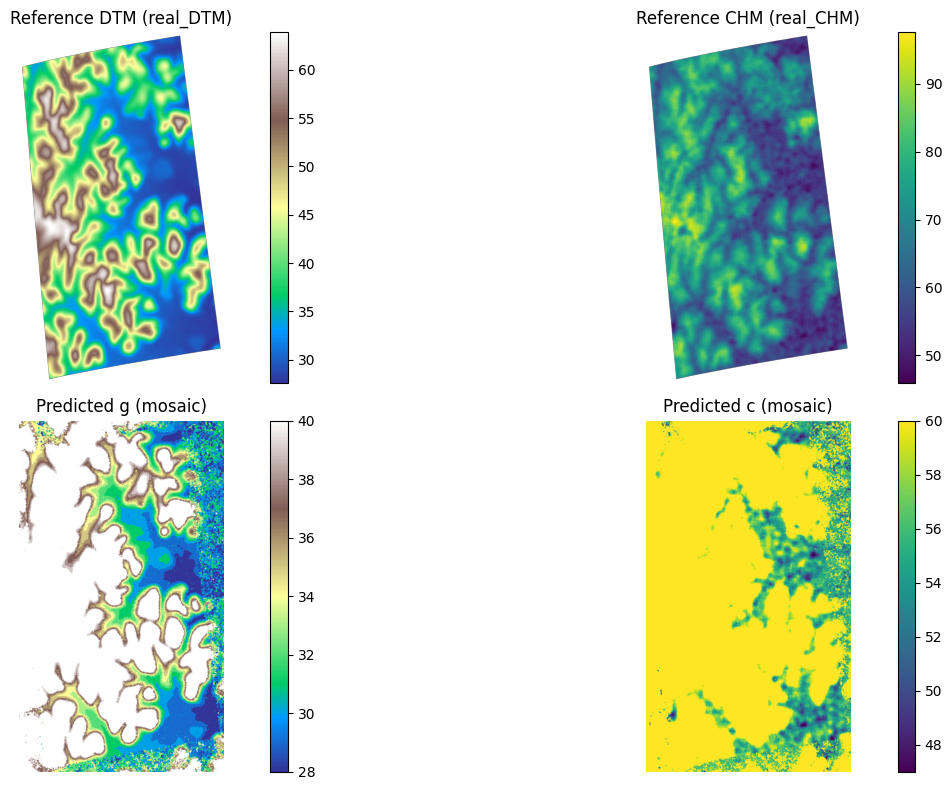

In [ ]:
# Load .mat reference images
mat_data = scipy.io.loadmat('dataset_Guiana_6FPimages_Pband.mat')
CHM = mat_data['CHM']
DTM = mat_data['DTM']
real_DTM = DTM + 25
real_CHM = DTM + CHM + 25


# Visualize
plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.imshow(real_DTM, cmap='terrain')
plt.title('Reference DTM (real_DTM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(real_CHM, cmap='viridis')
plt.title('Reference CHM (real_CHM)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 3)
plt.imshow(pred_g, cmap='terrain')
plt.title('Predicted g (mosaic)')
plt.axis('off')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(pred_c, cmap='viridis')  
plt.title('Predicted c (mosaic)')
plt.axis('off')
plt.colorbar()



plt.tight_layout()
plt.show()



In [ ]:
plt.savefig("tsnn_vs_lidar.png")
np.savez("valid_eval_data.npz",
         true_chm=true_chm,
         pred_chm=predicted_chm,
         true_dtm=true_dtm,
         pred_dtm=predicted_dtm)


<Figure size 640x480 with 0 Axes>

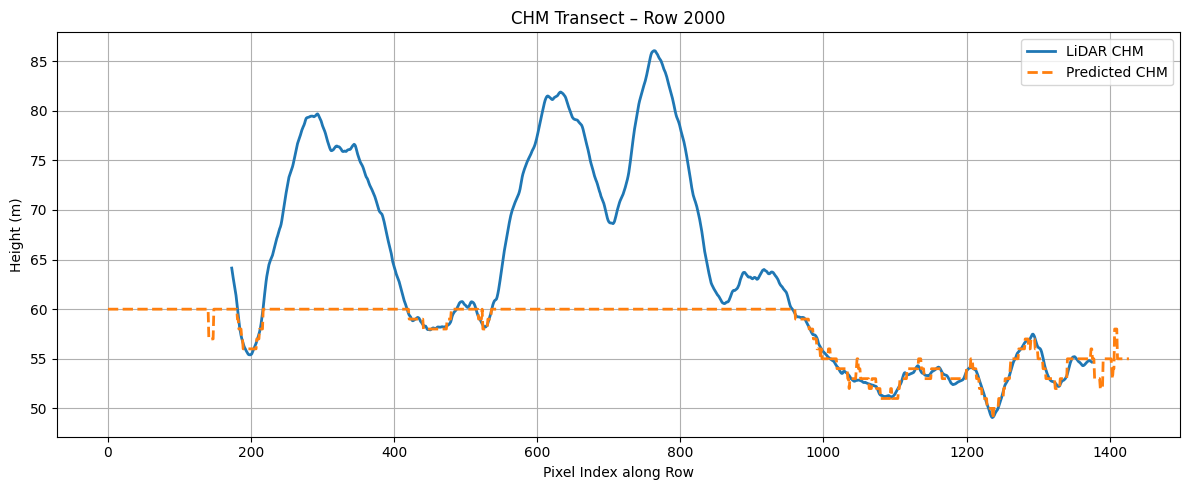

In [52]:
row = 2000  # pick any row with visible features
plt.figure(figsize=(12, 5))
plt.plot(real_CHM[row], label='LiDAR CHM', linewidth=2)
plt.plot(pred_c[row], label='Predicted CHM', linestyle='--', linewidth=2)
plt.xlabel("Pixel Index along Row")
plt.ylabel("Height (m)")
plt.title(f"CHM Transect – Row {row}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("transect_chm_row2000.png", dpi=300)
plt.show()
